# 3. Рекомендательная система (20 баллов)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [1]:
import pandas as pd
import numpy as np

In [2]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../Data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
anime.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../Data/anime/rating.csv.zip')
    ratings = ratings.head(300000) #Не хватало оперативки, зависало не доходя до построения декартового произведения
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных (1 балл)

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

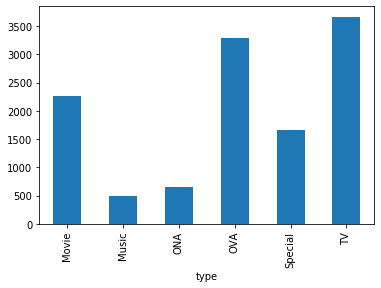

In [6]:
anime.groupby('type').count()['name'].plot(kind='bar')

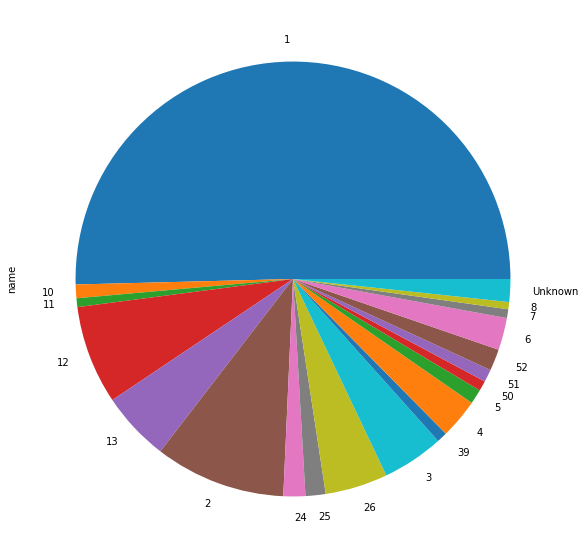

In [7]:
plt.figure(figsize=(16, 10))
episodes = anime.groupby('episodes').count()
episodes[episodes['name'] > 50]['name'].plot(kind='pie')

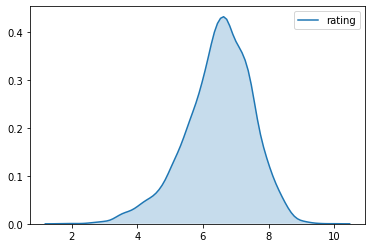

In [8]:
sns.kdeplot(anime['rating'], shade = True)

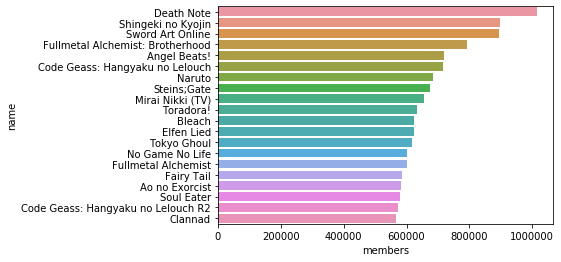

In [9]:
top_mems = anime.sort_values('members', ascending=False).head(20)
sns.barplot(data = top_mems, y='name', x='members')

## Жанры (4 балла)

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [10]:
from itertools import chain

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique()
genres = set(flatmap(genre_splitter, m_uniq))
genres = list(genres)

anime_genres = pd.DataFrame(index=anime.index)
for g in genres:
    anime_genres[g] = anime['genre'].str.contains(g).astype(int)
anime_genres.set_index(anime['name'], inplace = True)
print(anime_genres.shape)
anime_genres.head()

(12017, 43)


,Dementia,Sci-Fi,Supernatural,Historical,Super Power,Fantasy,Shounen,Parody,Comedy,Psychological,...,Shoujo Ai,Shounen Ai,Horror,Mecha,Ecchi,Action,Harem,Sports,Drama,Slice of Life
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Fullmetal Alchemist: Brotherhood,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
Gintama°,0,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
Steins;Gate,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gintama&#039;,0,1,0,1,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0


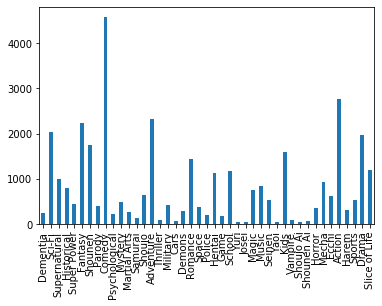

In [11]:
anime_genres.sum().plot(kind='bar')

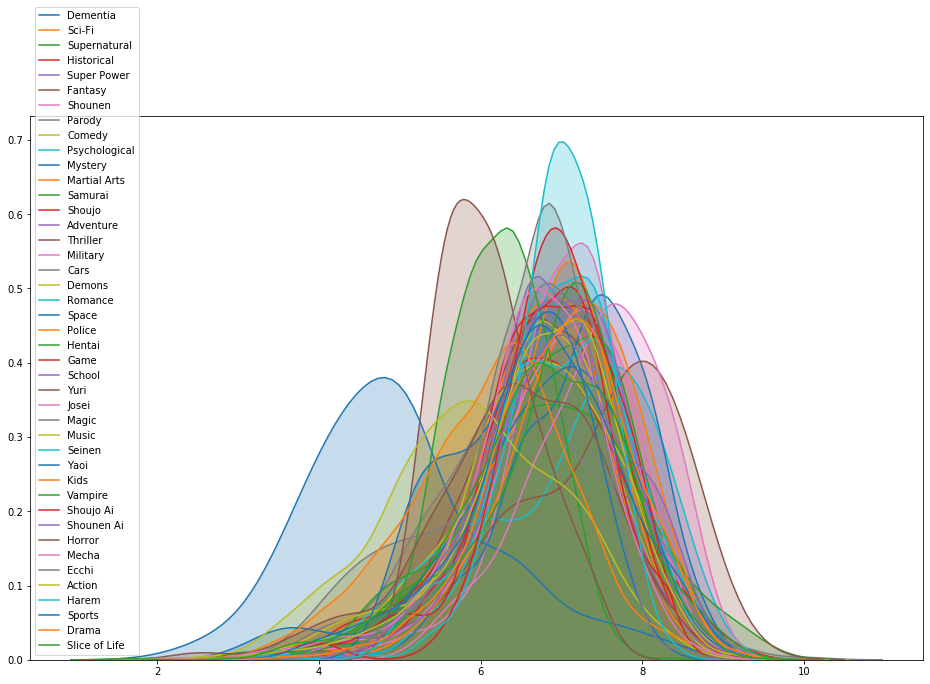

In [12]:
plt.figure(figsize=(16, 10))
for g in genres:
    df_temp = anime[anime['genre'].str.contains(g)]
    sns.kdeplot(df_temp['rating'], label = g, shade = True)


## Рейтинг (1 балл)

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

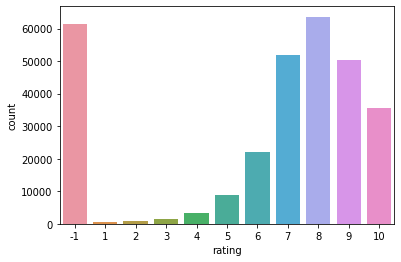

In [13]:
sns.countplot(x = 'rating',data = ratings)

## Фильтрация данных (5 баллов)

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [14]:
anime_watches = pd.DataFrame(index = anime['name'], columns = ['anime_reviews'])
rat_names = ratings.join(anime, on = 'anime_id', lsuffix='_left')
anime_watches['anime_reviews'] = rat_names.groupby('name').count()
anime_watches = anime_watches.fillna(0)
anime_watches

,anime_reviews
name,
Kimi no Na wa.,97.0
Fullmetal Alchemist: Brotherhood,1163.0
Gintama°,64.0
Steins;Gate,957.0
Gintama&#039;,145.0
...,...
Toushindai My Lover: Minami tai Mecha-Minami,0.0
Under World,0.0
Violence Gekiga David no Hoshi,0.0


In [15]:
user_ratings = pd.DataFrame(index = ratings['user_id'].unique(), columns = ['user_reviews'])
user_ratings['user_reviews'] = ratings.groupby('user_id').count()
user_ratings

,user_reviews
1,153
2,3
3,94
4,52
5,467
...,...
3089,6
3090,13
3091,17
3092,282


In [16]:
anime_ratings = ratings.join(other = anime, on='anime_id', lsuffix='_user', rsuffix='_anime')
anime_ratings = anime_ratings.join(other = anime_watches,  on='name')
anime_ratings = anime_ratings.join(other = user_ratings,  on='user_id')
anime_ratings['rating_user'] = np.where(anime_ratings['rating_user'] == -1, anime_ratings['rating_anime'], anime_ratings['rating_user'])
anime_ratings

med = anime_ratings.median()
anime_ratings = anime_ratings[anime_ratings['anime_reviews'] > med['anime_reviews']]
anime_ratings = anime_ratings[anime_ratings['user_reviews'] > med['user_reviews']]
anime_ratings

,user_id,anime_id,rating_user,name,genre,type,episodes,rating_anime,members,anime_reviews,user_reviews
302,5,6,8.0,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069.0,332.0,467
306,5,20,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,1088.0,467
309,5,30,1.0,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,26,8.32,461946.0,624.0,467
310,5,45,7.0,Rurouni Kenshin: Meiji Kenkaku Romantan,"Action, Adventure, Comedy, Historical, Romance...",TV,94,8.43,218928.0,217.0,467
311,5,47,8.0,Akira,"Action, Adventure, Horror, Military, Sci-Fi, S...",Movie,1,8.15,215897.0,306.0,467
...,...,...,...,...,...,...,...,...,...,...,...
299859,3092,22789,10.0,Barakamon,"Comedy, Slice of Life",TV,12,8.50,225927.0,341.0,282
299867,3092,24703,6.0,High School DxD BorN,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.71,192171.0,239.0,282
299871,3092,26349,10.0,Danna ga Nani wo Itteiru ka Wakaranai Ken,"Comedy, Seinen, Slice of Life",TV,13,7.55,122271.0,255.0,282
299873,3092,27655,8.0,Aldnoah.Zero 2nd Season,"Action, Mecha, Sci-Fi, Space",TV,12,7.15,149364.0,257.0,282


## Матрица user-item (3 балла)

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [17]:
anime_uniq = list(anime_ratings['name'].unique())
user_uniq = list(anime_ratings['user_id'].unique())
anime_indexes = { anime_uniq[i] : i for i in range(0, len(anime_uniq) ) }
user_indexes = { user_uniq[i] : i for i in range(0, len(user_uniq) ) }
ua_matrix = np.empty((len(user_uniq), len(anime_uniq)))
ua_matrix[:] = np.nan
ua_df = pd.DataFrame(data=ua_matrix, index=user_uniq, columns=anime_uniq)
for index, row in anime_ratings.iterrows():
    ua_df.at[row['user_id'], row['name']] = row['rating_user']
ua_df


,Trigun,Naruto,Neon Genesis Evangelion,Rurouni Kenshin: Meiji Kenkaku Romantan,Akira,Sen to Chihiro no Kamikakushi,Samurai Champloo,Dragon Ball,Dragon Ball GT,Great Teacher Onizuka,...,Higashi no Eden,Gosick,Darker than Black: Kuro no Keiyakusha Gaiden,Fairy Tail OVA,One Piece Film: Z,Naruto: Shippuuden Movie 6 - Road to Ninja,Berserk,Air,Kokoro Connect: Michi Random,Fruits Basket
5,8.0,6.0,1.00,7.0,8.0,8.00,8.0,6.0,1.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,10.00,NaN,NaN,NaN,NaN,9.0,7.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,7.0,NaN,9.00,NaN,8.0,8.00,7.0,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,6.0,10.00,NaN,7.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,8.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3057,NaN,9.0,8.32,NaN,NaN,9.00,NaN,10.0,5.0,NaN,...,8.03,NaN,6.0,NaN,NaN,9.0,NaN,NaN,NaN,7.0
3059,NaN,NaN,NaN,NaN,NaN,10.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3063,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3084,NaN,7.0,NaN,NaN,NaN,8.93,8.0,6.0,5.0,NaN,...,NaN,NaN,NaN,NaN,8.39,NaN,NaN,7.0,8.19,NaN


## Понижение размерности (1 балл)

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6, random_state=42)
df_pca = pca.fit_transform(ua_df.fillna(0))
df_pca.shape

(442, 6)

## Обучение kMeans (1 балл)

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

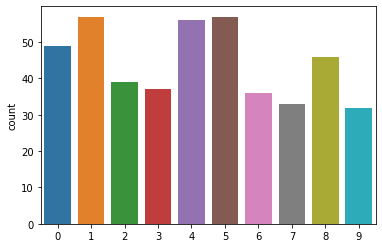

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_pca)
kmeans.labels_
matrix2 = np.concatenate((ua_matrix, kmeans.predict(df_pca).reshape((len(kmeans.labels_), 1))), axis=1)
sns.countplot(kmeans.labels_);

## Top 15 аниме (2 балла)

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [20]:
clust_rat = []
for cluster in range(kmeans.n_clusters):
    cluster_users = ua_df[kmeans.labels_ == cluster]
    clust_rat.append(cluster_users.mean().dropna().sort_values(ascending = False))
    print("Cluster " + str(cluster) + ":")
    print(clust_rat[cluster].head(15))
    print("")
    

Cluster 0:
Steins;Gate                                          9.544667
Fullmetal Alchemist: Brotherhood                     9.360930
Steins;Gate Movie: Fuka Ryouiki no Déjà vu           9.352414
Hunter x Hunter (2011)                               9.324687
Code Geass: Hangyaku no Lelouch R2                   9.302609
Fate/Zero 2nd Season                                 9.147381
Code Geass: Hangyaku no Lelouch                      9.028085
Tengen Toppa Gurren Lagann                           9.010625
Hellsing Ultimate                                    9.009000
Suzumiya Haruhi no Shoushitsu                        8.983478
One Punch Man                                        8.962439
Fate/stay night: Unlimited Blade Works 2nd Season    8.940000
Shinsekai yori                                       8.925385
Mononoke Hime                                        8.917368
Bakuman. 3rd Season                                  8.915000
dtype: float64

Cluster 1:
Steins;Gate                     

## Top 5 жанров (2 балла)

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [21]:
for cluster in range(kmeans.n_clusters):
    clust_anime = pd.DataFrame(clust_rat[cluster].head(100), columns = ['rating']).join(anime_genres)
    count_anime = clust_anime.drop('rating', axis = 1).sum().sort_values(ascending = False)
    print("Cluster " + str(cluster) + ":")
    print(count_anime.head(5))
    print("")

Cluster 0:
Action          40
Comedy          39
Drama           34
Supernatural    33
Shounen         30
dtype: int64

Cluster 1:
Action          40
Comedy          39
Drama           33
Supernatural    32
Shounen         27
dtype: int64

Cluster 2:
Comedy          44
Shounen         37
Action          37
Drama           33
Supernatural    31
dtype: int64

Cluster 3:
Comedy     45
Action     42
Shounen    33
Fantasy    32
Drama      31
dtype: int64

Cluster 4:
Action          39
Comedy          38
Romance         32
Shounen         31
Supernatural    31
dtype: int64

Cluster 5:
Action     44
Comedy     42
Drama      35
Shounen    35
Romance    34
dtype: int64

Cluster 6:
Comedy          48
Action          44
Drama           34
Supernatural    30
Romance         29
dtype: int64

Cluster 7:
Action          42
Supernatural    37
Drama           37
Comedy          37
Romance         29
dtype: int64

Cluster 8:
Action          46
Comedy          45
Shounen         35
Supernatural    33
Dra